In [1]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py
import time

In [2]:
pop_file_loc = "/home/pranavsatheesh/host_galaxies/merger_file_runs/"
pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001.hdf5"

In [3]:
pop = h5py.File(pop_file, 'r')
Mstar_merging = pop['merging_population']['Mstar'][:]
Mstar_non_merging = pop['non_merging_population']['Mstar'][:]

In [61]:
def generate_control_sample_restrictive(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10 and Mstar_dex_tol < 0.3):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"].append(z_tol)
        control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [62]:
def generate_control_sample(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"].append(z_tol)
        control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [63]:
control_def = generate_control_sample(pop)
control_restrictive = generate_control_sample_restrictive(pop)

Elapsed time: 34.36613965034485 seconds
Elapsed time: 108.6274824142456 seconds


In [64]:
Mstar_tol_max_non_restrictive = np.max(control_def['z_tol'])
Mstar_tol_max_restrictive = np.max(control_restrictive['z_tol'])

In [9]:
print(f"The maximum tolerance in z is {np.max(control_sample['z_tol']):.3f}")
print(f"The maximum tolerance in $M_{{\star}}$ is {np.max(control_sample['Mstar_dex_tol']):.3f}")
lengths_subhalo_ids = [len(sublist) for sublist in control_sample['subhalo_ids']]
print(f"The average number of control samples is {np.mean(lengths_subhalo_ids):.0f}")
print(f"The minimum number of control samples is {np.min(lengths_subhalo_ids):.0f}")

The maximum tolerance in z is 0.076
The maximum tolerance in $M_{\star}$ is 0.759
The average number of control samples is 151
The minimum number of control samples is 10


In [65]:
def weight_Mstar(i,pop,control):
    return 1  - np.abs(np.log10(pop["merging_population"]["Mstar"][i])- np.log10(control["Mstar"][i]))/control["Mstar_dex_tol"][i]

def weight_z(i,pop,control):
    return 1  - np.abs(np.log10(pop["merging_population"]["z"][i])- np.log10(control["z"][i]))/control["z_tol"][i]

def weight_tot(i,pop,control):
    return weight_z(i,pop,control)*weight_Mstar(i,pop,control)

def control_prop_avg(prop_key,index,pop,control):
    control_pop = control[prop_key][index]
    control_weights = weight_tot(index,pop,control)
    control_avg = np.sum(control_weights*control_pop)/np.sum(control_weights)
    return control_avg

In [66]:
N_mergers = len(pop['merging_population']["z"])

control_z_avg = np.array([control_prop_avg("z", i,pop,control_def) for i in range(N_mergers)])
control_Mstar_avg = np.array([control_prop_avg("Mstar", i,pop,control_def) for i in range(N_mergers)])

control_restrictive_z_avg = np.array([control_prop_avg("z", i,pop,control_restrictive) for i in range(N_mergers)])
control_restrictive_Mstar_avg = np.array([control_prop_avg("Mstar", i,pop,control_restrictive) for i in range(N_mergers)])

In [67]:
Mstar_binsize = 0.5  # specify the binsize
Mstar_min = 7
Mstar_max = 12
Nbins_Ms = int((Mstar_max-Mstar_min)/Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min,Mstar_max,Nbins_Ms)

z_binsize = 0.1  
z_min = 0
z_max = 5
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

Text(0.5, 0, '$\\log(M_{\\star}/M_{\\odot})$')

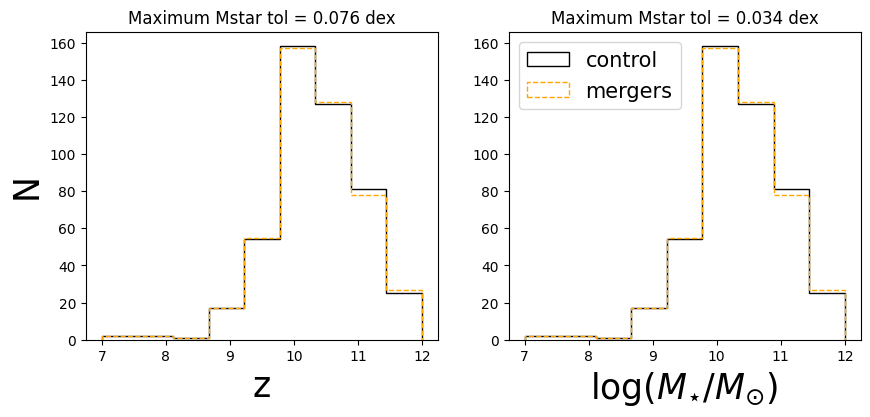

In [77]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(np.log10(control_Mstar_avg), bins=Mstar_bins,histtype="step",color="black",label="control")
ax[0].hist(np.log10(pop['merging_population']['Mstar']),bins=Mstar_bins,histtype="step",label="mergers",color="orange",linestyle="--")
ax[0].set_title(f"Maximum Mstar tol = %2.3f dex"%(Mstar_tol_max_non_restrictive))
ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("N",fontsize=25)


ax[1].hist(np.log10(control_restrictive_Mstar_avg), bins=Mstar_bins,histtype="step",color="black",label="control")
ax[1].hist(np.log10(pop['merging_population']['Mstar']),bins=Mstar_bins,histtype="step",label="mergers",color="orange",linestyle="--")
ax[1].set_title(f"Maximum Mstar tol = %2.3f dex"%(Mstar_tol_max_restrictive))
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)

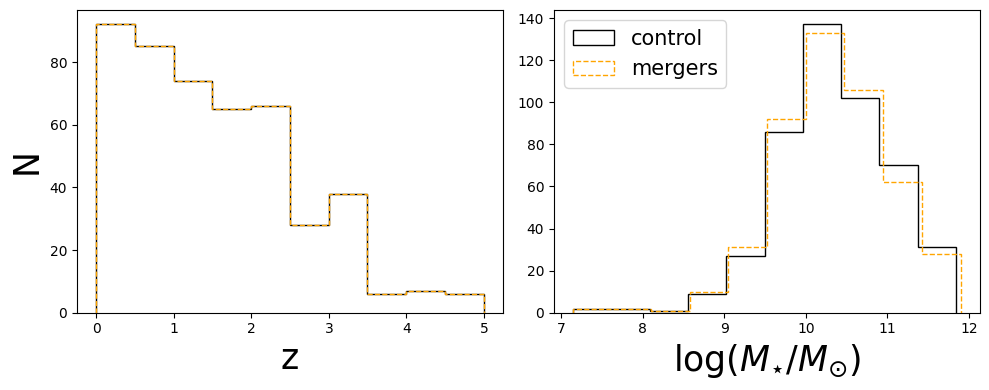

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
control_z_avg = np.array([control_prop_avg("z", i) for i in range(N_mergers)])
ax[0].hist(control_z_avg,histtype="step",color="black",label="control")
ax[0].hist(pop['merging_population']['z'],histtype="step",label="mergers",color="orange",linestyle="--")

ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("N",fontsize=25)

control_Mstar_avg = np.array([control_prop_avg("Mstar", i) for i in range(N_mergers)])
ax[1].hist(np.log10(control_Mstar_avg),histtype="step",color="black",label="control")
ax[1].hist(np.log10(pop['merging_population']['Mstar']),histtype="step",label="mergers",color="orange",linestyle="--")
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)
#ax[1].set_ylabel("N",fontsize=25)
fig.tight_layout()

In [76]:
D_z,p_value_z = ks_2samp(control_z_avg,pop['merging_population']['z'])
D_Mstar,p_value_Mstar = ks_2samp(np.log10(control_Mstar_avg),np.log10(pop['merging_population']['Mstar']))
print(f"Redshift matching gives KS statistic of {D_z:2.3f} and p-value of {p_value_z}")
print(f"Mstar matching gives KS statistic of {D_Mstar:.3f} and p-value of {p_value_Mstar}")

Redshift matching gives KS statistic of 0.017 and p-value of 0.9999998707742743
Mstar matching gives KS statistic of 0.015 and p-value of 0.9999999994509645


In [75]:
D_z,p_value_z = ks_2samp(control_restrictive_z_avg,pop['merging_population']['z'])
D_Mstar,p_value_Mstar = ks_2samp(np.log10(control_restrictive_Mstar_avg),np.log10(pop['merging_population']['Mstar']))
print(f"Redshift matching gives KS statistic of {D_z:2.3f} and p-value of {p_value_z}")
print(f"Mstar matching gives KS statistic of {D_Mstar:.3f} and p-value of {p_value_Mstar}")

Redshift matching gives KS statistic of 0.017 and p-value of 0.9999998707742743
Mstar matching gives KS statistic of 0.011 and p-value of 0.9999999999999998


In [ ]:
control_sample_file =  "control_sample.hdf5"

      

with h5py.File(control_sample_file, 'w') as f:
    for key, value in control_sample.items():
        if isinstance(value, list):
            group = f.create_group(key)
            for i, array in enumerate(value):
                group.create_dataset(str(i), data=array)
        else:
            f.create_dataset(key, data=value)

f.close()

In [ ]:
with h5py.File(control_sample_file, 'w') as f:
    for key, value in control_sample.items():
        # Define a variable-length data type
        vlen_dtype = h5py.special_dtype(vlen=np.dtype('float64'))
        
        # Create a dataset with the variable-length data type
        if isinstance(value, list):
            dset = f.create_dataset(key, (len(value),), dtype=vlen_dtype)
            dset[:] = value
        else:
            f.create_dataset(key, data=value)